In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import os

/home/tom/apps/cache/python-envs/insanely-fast-whisper/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Define the paths
data_root = '/home/tom/Python/Machine learning/pytorch/GaN'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])


In [4]:
# Define custom dataset class
#watermark images has normal names and non-watermark images has v2 at the tail of their name. Not all files have watermarked or non-watermarked pictures. sometimes the non-watermarked version is unavialble or vice versa
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.watermarked_folder = "watermarked"
        self.non_watermarked_folder = "non_watermarked"
        self.file_list = self._create_file_list()

    def _create_file_list(self):
        watermarked_path = os.path.join(self.root_dir, self.watermarked_folder)
        non_watermarked_path = os.path.join(self.root_dir, self.non_watermarked_folder)

        watermarked_files = os.listdir(watermarked_path)
        non_watermarked_files = os.listdir(non_watermarked_path)

        # Keep only the files that have a corresponding pair
        file_list = [file for file in watermarked_files if file.replace(".jpg", "v2.jpg") in non_watermarked_files]

        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        watermarked_filename = self.file_list[idx]
        non_watermarked_filename = watermarked_filename.replace(".jpg", "v2.jpg")

        watermarked_path = os.path.join(self.root_dir, self.watermarked_folder, watermarked_filename)
        non_watermarked_path = os.path.join(self.root_dir, self.non_watermarked_folder, non_watermarked_filename)

        watermarked_image = Image.open(watermarked_path)
        non_watermarked_image = Image.open(non_watermarked_path)

        if self.transform:
            watermarked_image = self.transform(watermarked_image)
            non_watermarked_image = self.transform(non_watermarked_image)

        return watermarked_image, non_watermarked_image

In [5]:
# Instantiate the dataset and data loader
dataset = Dataset(data_root, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
# Check the shape of the dataset
for batch in data_loader:
    watermark_images, non_watermark_images = batch
    print("Shape of watermark images:", watermark_images.shape)
    print("Shape of non-watermark images:", non_watermark_images.shape)
    break  # Only printing the shape of the first batch for demonstration purposes


Shape of watermark images: torch.Size([32, 3, 64, 64])
Shape of non-watermark images: torch.Size([32, 3, 64, 64])


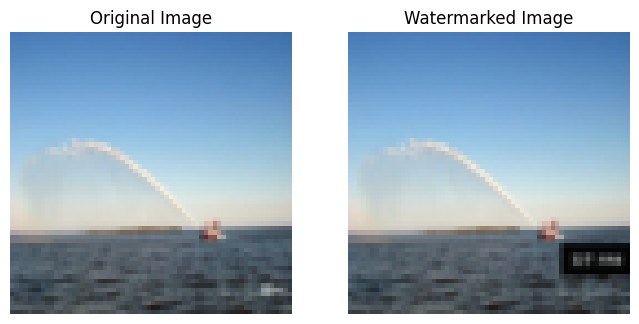

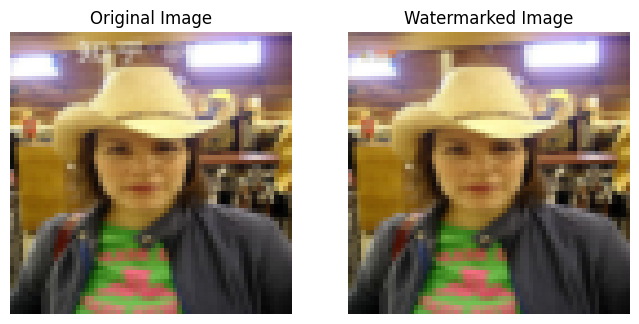

In [7]:
# Visualize the original and watermarked images
i=0
for batch in data_loader:
    i=i+1
    watermark_images, non_watermark_images = batch

    # Convert to numpy arrays
    watermark_np = watermark_images[0].permute(1, 2, 0).numpy()
    non_watermark_np = non_watermark_images[0].permute(1, 2, 0).numpy()

    # Display original and watermarked images using matplotlib
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(non_watermark_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Watermarked Image")
    plt.imshow(watermark_np)
    plt.axis("off")

    plt.show()
    if i==2:
        break # Only visualizing the first batch for demonstration purposes
    else:
        pass

In [8]:
class GeneratorUNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(GeneratorUNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # maxpooling layer divides input size by two
        )

        # Center
        self.center = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  #maxpooling layer divides input size by two. as this is the second layer of maxppoling. the input size is now one by forth
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, output_channels, kernel_size=2, stride=2) # In this layer , the input is upsampled by two. 
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder(x)
        # Center
        center = self.center(enc1)
        # Decoder
        dec1 = self.decoder(center)

        return dec1


In [9]:
# Define the pix2pixHD discriminator. This function gives a true or false value in 0 or 1.
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )



    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
# Instantiate the generator and discriminator
input_channels = 3  # For RGB images
output_channels = 3  # For RGB output
generator = GeneratorUNet(input_channels, output_channels)
discriminator = Discriminator(input_channels + output_channels)

# Define loss function and optimizer
criterion = nn.MSELoss()
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [11]:
import torch.nn.functional as F

# Training parameters
num_epochs = 5

# Move models to device
generator = generator.to(device)
discriminator = discriminator.to(device)

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (watermarked_images, non_watermarked_images) in enumerate(data_loader):
        # we first generate outputs from 'descriminator' by using real images and fake images (fake images are generated by 'generator' with noise as input) and then we calculate loss for fake and real image cases and then use it to train descriminator (losses from outputs of descriminator function for real images and fake images are used in backpropogation). Then, 'generator' is trained  by loss generated from discriminator' output of fake images
            # Train discriminator with real images
        # Move data to device
        watermarked_images = watermarked_images.to(device)
        non_watermarked_images = non_watermarked_images.to(device)

        # Adversarial ground truth for discriminator
        valid = torch.ones((watermarked_images.size(0), 1, 64, 64), requires_grad=False).to(device)
        fake = torch.zeros((watermarked_images.size(0), 1, 64, 64), requires_grad=False).to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------

        discriminator_optimizer.zero_grad()

        # Generate non-watermarked images
        generated_images = generator(watermarked_images)
        generated_images = F.interpolate(generated_images, size=(64, 64), mode='bilinear', align_corners=False)

        # Concatenate pairs for discriminator input
        real_pair = torch.cat((watermarked_images, non_watermarked_images), 1)
        fake_pair = torch.cat((watermarked_images, generated_images.detach()), 1)

        # Discriminator loss for real and fake pairs
        real_loss = criterion(discriminator(real_pair), valid)
        fake_loss = criterion(discriminator(fake_pair), fake)

        # Total discriminator loss
        total_discriminator_loss = 0.5 * (real_loss + fake_loss)

        # Backward and optimize
        total_discriminator_loss.backward()
        discriminator_optimizer.step()

        # -----------------
        #  Train Generator
        # -----------------

        generator_optimizer.zero_grad()

        # Get the output of the discriminator
        discriminator_output = discriminator(torch.cat((watermarked_images, generated_images), 1))
        
        # Generator loss
        generator_loss = criterion(discriminator_output, valid)


        # Backward and optimize
        generator_loss.backward()
        generator_optimizer.step()

        # Print training information
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(data_loader)}], "
                f"Generator Loss: {generator_loss.item():.4f}, "
                f"Discriminator Loss: {total_discriminator_loss.item():.4f}"
            )

    # Save generated images at the end of each epoch (optional)
    with torch.no_grad():
        generated_samples = generator(watermarked_images)
        # Save or visualize generated samples if needed

    # Save model checkpoints at the end of each epoch (optional)
    torch.save(generator.state_dict(), f"generator_epoch_{epoch + 1}.pth")
    torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch + 1}.pth")


Epoch [0/5], Batch [0/428], Generator Loss: 0.2360, Discriminator Loss: 0.2524
Epoch [0/5], Batch [100/428], Generator Loss: 0.2563, Discriminator Loss: 0.2458
Epoch [0/5], Batch [200/428], Generator Loss: 0.2658, Discriminator Loss: 0.2372
Epoch [0/5], Batch [300/428], Generator Loss: 0.3017, Discriminator Loss: 0.2231
Epoch [0/5], Batch [400/428], Generator Loss: 0.3616, Discriminator Loss: 0.2009
Epoch [1/5], Batch [0/428], Generator Loss: 0.3734, Discriminator Loss: 0.2194
Epoch [1/5], Batch [100/428], Generator Loss: 0.3527, Discriminator Loss: 0.1930
Epoch [1/5], Batch [200/428], Generator Loss: 0.3876, Discriminator Loss: 0.1930
Epoch [1/5], Batch [300/428], Generator Loss: 0.4596, Discriminator Loss: 0.1574
Epoch [1/5], Batch [400/428], Generator Loss: 0.3437, Discriminator Loss: 0.1965
Epoch [2/5], Batch [0/428], Generator Loss: 0.5188, Discriminator Loss: 0.1618
Epoch [2/5], Batch [100/428], Generator Loss: 0.5080, Discriminator Loss: 0.1676
Epoch [2/5], Batch [200/428], Gene

In [12]:
# Specify the path to your inference images
inference_images_path = '/home/tom/test/'

# Create ImageFolder dataset for inference
inference_dataset = datasets.ImageFolder(root=inference_images_path, transform=transform)
# Create DataLoader for inference
inference_data_loader = DataLoader(inference_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)


In [13]:
for x,y in inference_data_loader:
    print(x.shape)
    break

torch.Size([1, 3, 64, 64])


In [14]:
# Create a directory to save the generated images
from torchvision.utils import save_image

# Inference on new images
generator.eval()


output_directory = '/home/tom/test2/'
os.makedirs(output_directory, exist_ok=True)

# Iterate over the new images for inference
for idx, (new_image, _) in enumerate(inference_data_loader):
    # Move data to device
    new_image = new_image.to(device)

    # Generate output images without watermarks
    with torch.no_grad():
        generated_output = generator(new_image)

    # Save or visualize the generated images
    output_file_path = os.path.join(output_directory, f'generated_output_{idx + 1}.png')
    save_image(generated_output.squeeze(0), output_file_path)  # Squeeze to remove batch dimension

In [ ]:

def filter_and_delete_files(directory):
    files = os.listdir(directory)
    files_to_keep = set()

    for file in files:
        base_name, extension = os.path.splitext(file)
        if base_name.endswith('v2'):
            # If the file has 'v2' at the end, keep both versions
            original_file = base_name[:-2] + extension
            files_to_keep.add(original_file)
            files_to_keep.add(file)

    # Delete files that don't have a 'v2' counterpart
    for file in files:
        if file not in files_to_keep:
            file_path = os.path.join(directory, file)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

# Specify the directory path
directory_path = '/home/tom/Python/Machine learning/pytorch/data/new/WatermarkDataset/images/train'

# Call the function to filter and delete files
filter_and_delete_files(directory_path)


In [ ]:

import shutil

# Assuming your images are in a directory named "images"
image_directory = "/home/tom/Python/Machine learning/pytorch/data/new/train/"
watermarked_folder = "watermarked"
non_watermarked_folder = "non_watermarked"

# Create the folders if they don't exist
os.makedirs(watermarked_folder, exist_ok=True)
os.makedirs(non_watermarked_folder, exist_ok=True)

# List all files in the directory
all_files = os.listdir(image_directory)

# Filter pairs of watermarked and non-watermarked images
for filename in all_files:
    # Check if the filename ends with "v2.jpg" (non-watermarked)
    if filename.endswith("v2.jpg"):
        non_watermarked_filename = filename
        # Construct the watermarked filename
        watermarked_filename = filename.replace("v2.jpg", ".jpg")

        # Check if the watermarked version exists
        if watermarked_filename in all_files:
            # Move the files to their respective folders
            shutil.move(os.path.join(image_directory, watermarked_filename), os.path.join(watermarked_folder, watermarked_filename))
            shutil.move(os.path.join(image_directory, non_watermarked_filename), os.path.join(non_watermarked_folder, non_watermarked_filename))
            print("Moved:", watermarked_filename, non_watermarked_filename)
        else:
            print("Skipping:", filename, "as the watermarked version is not found.")